In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib ipympl

NEURONS_FILE = "basal_ganglia_neurons.yaml"
NETWORK_FILE = "basal_ganglia_network.yaml"

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

Tshort = 1000 # ms
Tlong = 8000  # ms
dt = 0.1 # ms

points_per_bin = 10      # bins 1 ms wide
sampling_frequency = 1e3 # 1 kHz sampling frequency
burn_in_millis = 300    # the first part of the record to discard (ms)

n_trials = 10

In [3]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy.stats import entropy

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    print(f"f peak {f[np.argmax(PSD)]}")
    beta_mask = (f>12)&(f<30)
    return np.trapz(PSD[beta_mask], x=f[beta_mask])

def spectral_entropy(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (Tshort - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (Tshort - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    psd_normalized = PSD / np.trapz(PSD, x=f)
    spectral_entropy_value = entropy(psd_normalized, base=2)

    return spectral_entropy_value

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [30]:
def plot_spectrum(sn):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        spikes = sn.populations[pop].get_data()['spikes']
        binned_spikes = bin_spikes(spikes)
        binned_spikes = binned_spikes[burn_in_millis:]
        T = len(binned_spikes)
        print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")
        f, PSD = welch(binned_spikes, 
                       sampling_frequency, 
                       nperseg=T/2, 
                       noverlap=T/4,
                       nfft=None, 
                       scaling='density', 
                       window='hamming')
    
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale('log')
    print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(0,150)
    
def plot_signals(sn):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        binned_spikes = bin_spikes(sn.populations[pop].get_data()['spikes'])
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax.plot(tt, instantaneous_fr)
        ax.plot(tt, bandpass(instantaneous_fr, [12, 24], 1000), label="beta")
        ax.plot(tt, bandpass(instantaneous_fr, [30, 140], 1000), label="gamma")
        ax.set_ylabel(pop)
    ax.set_xlim(1.5, 2)
    fig.suptitle("Instantaneous firing rate [Hz]")
    ax.set_xlabel("time [s]")

In [5]:
from quilt.builder import NeuronCatalogue, SpikingNetwork
neuron_catalogue = NeuronCatalogue.from_yaml(NEURONS_FILE)
sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

# Magic super clean params: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}

# sn.rescale_populations(1.0)
# sn.rescale_connectivity(1.0)
# sn.rescale_weights(1.0)
# sn.rescale_delays(1.0)

poisson_rescale = 1.97

sn.build()

Output()

In [6]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)
# plt.show()

## Input/Output

In [7]:
# pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [8]:
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45 * poisson_rescale)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45 * poisson_rescale) 

## Run and get spikes

In [9]:
sn.run(dt=dt, time=Tshort)

Running network consisting of 14622 neurons for 10000 timesteps
--------------------------------------------------
**************************************************
Simulation took 15 s	(1.5957 ms/step)
	Gathering time avg: 0.0271 us/step
	Inject time avg: 128.741 us/step
Population evolution stats:
	0:
		evolution:	437.969 us/step	---	72 ns/step/neuron
		spike emission:	34.1141 us/step	---	5 ns/step/neuron
	1:
		evolution:	426.983 us/step	---	71 ns/step/neuron
		spike emission:	75.6771 us/step	---	12 ns/step/neuron
	2:
		evolution:	76.9476 us/step	---	183 ns/step/neuron
		spike emission:	30.5123 us/step	---	72 ns/step/neuron
	3:
		evolution:	107.841 us/step	---	138 ns/step/neuron
		spike emission:	26.3193 us/step	---	33 ns/step/neuron
	4:
		evolution:	57.7864 us/step	---	222 ns/step/neuron
		spike emission:	5.9266 us/step	---	22 ns/step/neuron
	5:
		evolution:	67.7395 us/step	---	166 ns/step/neuron
		spike emission:	6.318 us/step	---	15 ns/step/neuron
	6:
		evolution:	100.577 us/step

In [10]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

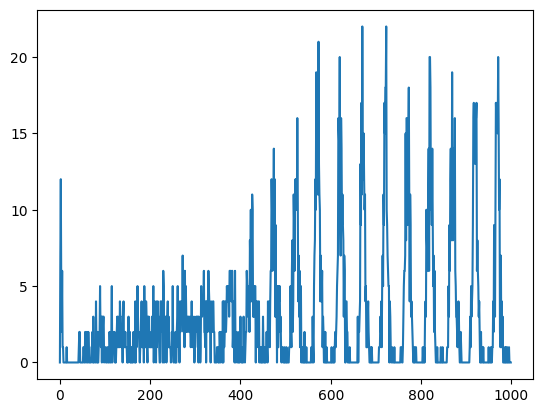

In [11]:
fig,ax = plt.subplots()
plt.plot(bin_spikes(spikes["GPeTA"]))
plt.show()

In [12]:
beta_power(sn, "GPeTA")

f peak 19.999999999999996


15.750867883229775

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [13]:
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

In [14]:
def build_network(poisson_rescale, rescale_weights):
    global neuron_catalogue
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    # sn.rescale_populations(0.2)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    # sn.rescale_delays(1)
    
    sn.build()

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    sn.run(dt=0.1, time=Tshort)
    return beta_power(sn, "GPeTA")

In [15]:
set_verbosity(0) # Turns off C++ outputs

study_power = optuna.create_study(direction = 'maximize')
study_power.optimize(optimize_beta_power, n_trials = n_trials, n_jobs = 3, catch=(ValueError, TypeError))

[I 2024-01-26 16:45:21,999] A new study created in memory with name: no-name-cc1404d6-dcba-4545-b7bb-e2586d2d5a7c
[I 2024-01-26 16:45:41,535] Trial 0 finished with value: 0.05938129988360201 and parameters: {'poisson_rescale': 0.392252102806934, 'weight_rescale': 0.4469852203125453}. Best is trial 0 with value: 0.05938129988360201.


f peak 11.428571428571427


[I 2024-01-26 16:46:02,669] Trial 1 finished with value: 0.07068093997403305 and parameters: {'poisson_rescale': 0.4497176629033939, 'weight_rescale': 0.5408151835290015}. Best is trial 1 with value: 0.07068093997403305.


f peak 11.428571428571427


[I 2024-01-26 16:46:24,843] Trial 2 finished with value: 0.0067058906391138035 and parameters: {'poisson_rescale': 0.698848675983088, 'weight_rescale': 1.0915816158054792}. Best is trial 1 with value: 0.07068093997403305.


f peak 11.428571428571427


[I 2024-01-26 16:46:47,265] Trial 3 finished with value: 0.04529152744662736 and parameters: {'poisson_rescale': 0.9469812095679037, 'weight_rescale': 1.967194870891349}. Best is trial 1 with value: 0.07068093997403305.


f peak 297.1428571428571


[I 2024-01-26 16:47:10,188] Trial 4 finished with value: 0.017576223711301478 and parameters: {'poisson_rescale': 0.28323642026617935, 'weight_rescale': 0.7266692880822175}. Best is trial 1 with value: 0.07068093997403305.


f peak 8.57142857142857


[I 2024-01-26 16:47:32,648] Trial 5 finished with value: 7.992960053209051 and parameters: {'poisson_rescale': 1.490585849230396, 'weight_rescale': 1.0255473465334684}. Best is trial 5 with value: 7.992960053209051.


f peak 19.999999999999996


[I 2024-01-26 16:47:55,854] Trial 6 finished with value: 14.078258032475661 and parameters: {'poisson_rescale': 1.4927407329365536, 'weight_rescale': 1.3939757897997143}. Best is trial 6 with value: 14.078258032475661.


f peak 17.14285714285714


[I 2024-01-26 16:48:23,141] Trial 7 finished with value: 0.12403584683085381 and parameters: {'poisson_rescale': 1.6852253928498562, 'weight_rescale': 0.4519697430208548}. Best is trial 6 with value: 14.078258032475661.


f peak 348.5714285714285


[I 2024-01-26 16:48:47,049] Trial 8 finished with value: 0.09227496121706008 and parameters: {'poisson_rescale': 1.4507767233853812, 'weight_rescale': 0.608375378132451}. Best is trial 6 with value: 14.078258032475661.


f peak 437.1428571428571


[I 2024-01-26 16:49:09,202] Trial 9 finished with value: 0.0031959923056057143 and parameters: {'poisson_rescale': 0.6700517008432172, 'weight_rescale': 1.163725336389319}. Best is trial 6 with value: 14.078258032475661.


f peak 65.71428571428571


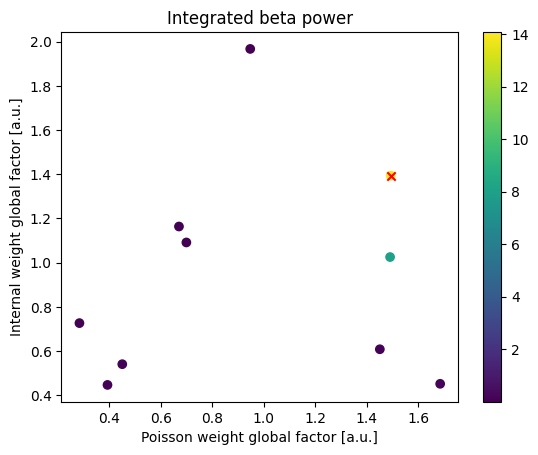

In [16]:
x = []
y = []
z = []
for trial in study_power.trials:
    x += [trial.params['poisson_rescale']]
    y += [trial.params['weight_rescale']]
    z += [trial.value]

fig, ax = plt.subplots()
plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_power.best_params['poisson_rescale'],study_power.best_params['weight_rescale'], marker="x", color="r")
plt.xlabel("Poisson weight global factor [a.u.]")
plt.ylabel("Internal weight global factor [a.u.]")
plt.title("Integrated beta power")

plt.show()

## Plot best params

In [17]:
set_verbosity(1)
best_params = study_power.best_params

print(best_params)
print(study_power.best_value)

sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
sn.run(dt=dt, time=Tlong)

Output()

{'poisson_rescale': 1.4927407329365536, 'weight_rescale': 1.3939757897997143}
14.078258032475661


Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 160 s	(2.01031 ms/step)
	Gathering time avg: 0.0800375 us/step
	Inject time avg: 170.823 us/step
Population evolution stats:
	0:
		evolution:	574.014 us/step	---	95 ns/step/neuron
		spike emission:	58.2186 us/step	---	9 ns/step/neuron
	1:
		evolution:	533.502 us/step	---	88 ns/step/neuron
		spike emission:	83.8239 us/step	---	13 ns/step/neuron
	2:
		evolution:	104.061 us/step	---	247 ns/step/neuron
		spike emission:	22.2092 us/step	---	52 ns/step/neuron
	3:
		evolution:	133.329 us/step	---	170 ns/step/neuron
		spike emission:	21.2368 us/step	---	27 ns/step/neuron
	4:
		evolution:	72.2767 us/step	---	277 ns/step/neuron
		spike emission:	8.64285 us/step	---	33 ns/step/neuron
	5:
		evolution:	84.8204 us/step	---	207 ns/step/neuron
		spike emission:	6.0041 us/step	---	14 ns/step/neuron
	6:
		evolution:	123.172 

Mean firing rate D1 is 0.4 Hz
Mean firing rate D2 is 2.0 Hz
Mean firing rate FSN is 24.4 Hz
Mean firing rate GPeTI is 53.2 Hz
Mean firing rate GPeTA is 12.8 Hz
Mean firing rate STN is 14.3 Hz
Mean firing rate SNR is 22.5 Hz
F resolution 0.26 Hz


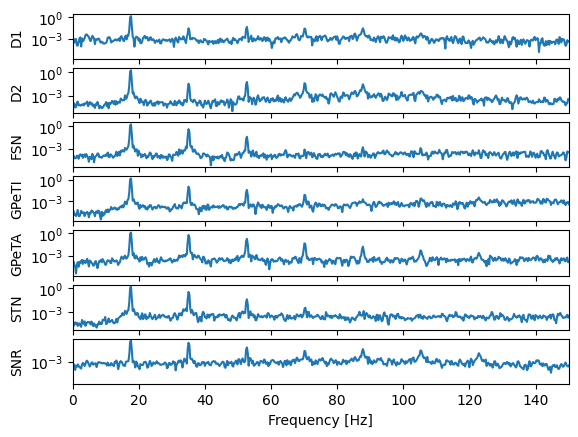

In [18]:
plot_spectrum(sn)

## Time signal analysis

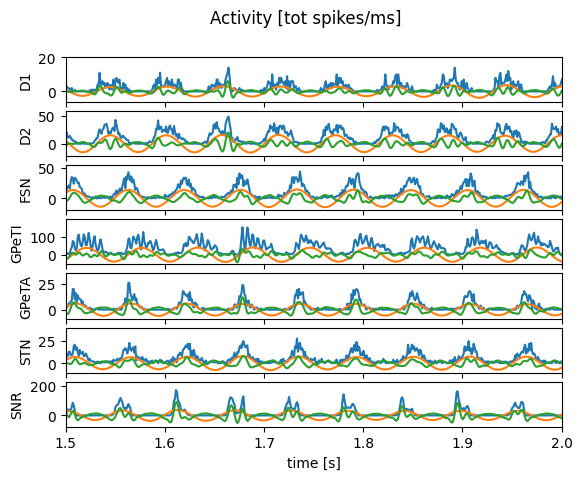

In [19]:
plot_signals(sn)

## Spectral entropy

In [20]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972):
    global neuron_catalogue    
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)
    # sn.rescale_populations(1.0)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    # sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [D1_freq, 0.45],
                          D2    = [D2_freq, 0.45]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy(trial):
    sn = build_network(trial.suggest_float("D1_freq", 800 , 1200 ),
                       trial.suggest_float("D2_freq", 800, 1200))    
    sn.run(dt=0.1, time=Tshort)
    return spectral_entropy(sn, "D1")

In [21]:
set_verbosity(0) 

study_entropy = optuna.create_study(direction = 'minimize')
study_entropy.optimize(optimize_spectral_entropy, n_trials = n_trials, n_jobs = 1, catch=(ValueError, TypeError))

[I 2024-01-26 16:51:56,880] A new study created in memory with name: no-name-fb8ab85d-56e0-4971-bdfd-df3f88647f83
[I 2024-01-26 16:52:22,575] Trial 0 finished with value: 5.456571204877173 and parameters: {'D1_freq': 931.1663024724456, 'D2_freq': 898.8896409015164}. Best is trial 0 with value: 5.456571204877173.
[I 2024-01-26 16:52:47,924] Trial 1 finished with value: 5.476545181237995 and parameters: {'D1_freq': 1195.3977792997234, 'D2_freq': 1119.4203093869578}. Best is trial 0 with value: 5.456571204877173.
[I 2024-01-26 16:53:14,611] Trial 2 finished with value: 5.042038366425461 and parameters: {'D1_freq': 1005.7352738906636, 'D2_freq': 855.9028877993322}. Best is trial 2 with value: 5.042038366425461.
[I 2024-01-26 16:53:38,686] Trial 3 finished with value: 4.322962251379688 and parameters: {'D1_freq': 1005.1140699309692, 'D2_freq': 852.4207901331605}. Best is trial 3 with value: 4.322962251379688.
[I 2024-01-26 16:54:05,538] Trial 4 finished with value: 7.054107977552799 and par

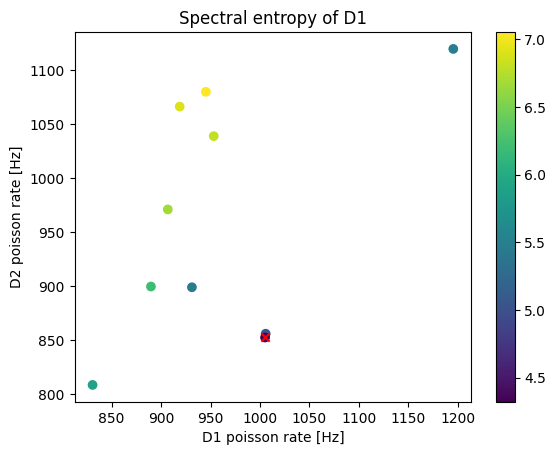

In [22]:
x = []
y = []
z = []
for trial in study_entropy.trials:
    x += [trial.params['D1_freq']]
    y += [trial.params['D2_freq']]
    z += [trial.value]

fig, ax = plt.subplots()

plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_entropy.best_params['D1_freq'],study_entropy.best_params['D2_freq'], marker="x", color="r")

plt.xlabel("D1 poisson rate [Hz]")
plt.ylabel("D2 poisson rate [Hz]")
plt.title("Spectral entropy of D1")
plt.show()

In [23]:
set_verbosity(1)
best_params = study_entropy.best_params

print(best_params)
print(study_entropy.best_value)

sn = build_network(**best_params)
# sn = build_network(D1_freq=best_params['D1_freq'], D2_freq=best_params['D2_freq'])
sn.run(dt=dt, time=Tlong)

{'D1_freq': 1005.1140699309692, 'D2_freq': 852.4207901331605}
4.322962251379688
Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 168 s	(2.10271 ms/step)
	Gathering time avg: 0.067 us/step
	Inject time avg: 165.517 us/step
Population evolution stats:
	0:
		evolution:	596.377 us/step	---	99 ns/step/neuron
		spike emission:	55.5994 us/step	---	9 ns/step/neuron
	1:
		evolution:	558.111 us/step	---	93 ns/step/neuron
		spike emission:	94.5713 us/step	---	15 ns/step/neuron
	2:
		evolution:	104.286 us/step	---	248 ns/step/neuron
		spike emission:	32.6379 us/step	---	77 ns/step/neuron
	3:
		evolution:	141.444 us/step	---	181 ns/step/neuron
		spike emission:	30.1384 us/step	---	38 ns/step/neuron
	4:
		evolution:	75.8429 us/step	---	291 ns/step/neuron
		spike emission:	8.15945 us/step	---	31 ns/step/neuron
	5:
		evolution:	88.6441 us/step	---	217 ns/step/neuron
		sp

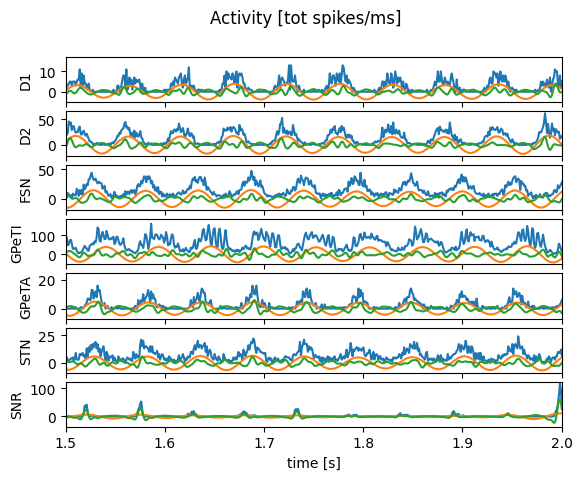

In [24]:
plot_signals(sn)

## More parameters

In [25]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
                    FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
                    weight_delta=0, delay_delta=0.0):
    
    global neuron_catalogue
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    # sn.rescale_populations(0.1)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    # sn.rescale_delays(1)
    for projection in sn.features_dict['projections']:
        projection['features']['weight_delta'] = weight_delta
        # projection['features']['delay_delta'] = delay_delta
        if projection['name'] == "FSN->D1":
            projection['features']['weight'] = FSNtoD1_w
        if projection['name'] == "FSN->D2":
            projection['features']['weight'] = FSNtoD2_w
        
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [D1_freq, D1_weight],
                          D2    = [D2_freq, D2_weight]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy_2(trial):

    params_intervals = dict(D1_freq = [1000,1300], D2_freq = [800, 1100], D1_weight=[0.35, 0.55], D2_weight=[0.35, 0.55], 
                    FSNtoD1_w=[5.6, 7.6], FSNtoD2_w=[3.8, 5.8], 
                    weight_delta=[0, 1], delay_delta=[0,0.5])
    
    params_suggestions = dict()
    for param_name in params_intervals.keys():
        params_suggestions[param_name] = trial.suggest_float(param_name, *(params_intervals[param_name]))
    # params_default = dict(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
    #                 FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
    #                 weight_delta=0, delay_delta=0.0)
    sn = build_network(**params_suggestions)    
    sn.run(dt=0.1, time=Tshort)
    return spectral_entropy(sn, "D1")

In [26]:
set_verbosity(0) 

study_entropy2 = optuna.create_study(direction = 'minimize', study_name="entropy2")
study_entropy2.optimize(optimize_spectral_entropy_2, n_trials = n_trials, n_jobs = 3, catch=(RuntimeError))

[I 2024-01-26 16:59:09,082] A new study created in memory with name: entropy2
[I 2024-01-26 17:00:09,986] Trial 0 finished with value: 4.902174592823481 and parameters: {'D1_freq': 1290.5352581936029, 'D2_freq': 980.0895121958254, 'D1_weight': 0.4915339531999473, 'D2_weight': 0.525192655602161, 'FSNtoD1_w': 6.715840655683681, 'FSNtoD2_w': 3.8721678597301583, 'weight_delta': 0.3788625291265064, 'delay_delta': 0.07261006599205067}. Best is trial 0 with value: 4.902174592823481.
[I 2024-01-26 17:00:31,236] Trial 1 finished with value: 4.728467091142619 and parameters: {'D1_freq': 1103.4889978179508, 'D2_freq': 804.9446083894926, 'D1_weight': 0.47331112783737317, 'D2_weight': 0.5428243269613233, 'FSNtoD1_w': 6.891034696701063, 'FSNtoD2_w': 4.093676928308588, 'weight_delta': 0.3643661372204595, 'delay_delta': 0.10444841762899876}. Best is trial 1 with value: 4.728467091142619.
[I 2024-01-26 17:00:31,246] Trial 2 finished with value: 4.564587749263339 and parameters: {'D1_freq': 1093.0283156

In [27]:
results_df = study_entropy2.trials_dataframe()
results_df.to_csv('entropy2_eeee.csv', index=False)

In [28]:
set_verbosity(1)
best_params = study_entropy2.best_params

print(best_params)
print(study_entropy2.best_value)

sn = build_network(**best_params)

sn.run(dt=dt, time=Tlong)

{'D1_freq': 1293.0394581723492, 'D2_freq': 849.2632818855142, 'D1_weight': 0.48699389803622867, 'D2_weight': 0.45292109432240946, 'FSNtoD1_w': 6.601472384463392, 'FSNtoD2_w': 4.944007754005588, 'weight_delta': 0.117008044548359, 'delay_delta': 0.2322152084677196}
2.8442255214256886
Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 170 s	(2.13325 ms/step)
	Gathering time avg: 0.0578375 us/step
	Inject time avg: 187.977 us/step
Population evolution stats:
	0:
		evolution:	588.981 us/step	---	98 ns/step/neuron
		spike emission:	78.7475 us/step	---	13 ns/step/neuron
	1:
		evolution:	553.339 us/step	---	92 ns/step/neuron
		spike emission:	92.8029 us/step	---	15 ns/step/neuron
	2:
		evolution:	103.982 us/step	---	247 ns/step/neuron
		spike emission:	31.2088 us/step	---	74 ns/step/neuron
	3:
		evolution:	139.607 us/step	---	178 ns/step/neuron
		spike emission:	31

Mean firing rate D1 is 2.2 Hz
Mean firing rate D2 is 2.1 Hz
Mean firing rate FSN is 35.7 Hz
Mean firing rate GPeTI is 80.0 Hz
Mean firing rate GPeTA is 9.4 Hz
Mean firing rate STN is 18.0 Hz
Mean firing rate SNR is 0.5 Hz
F resolution 0.26 Hz


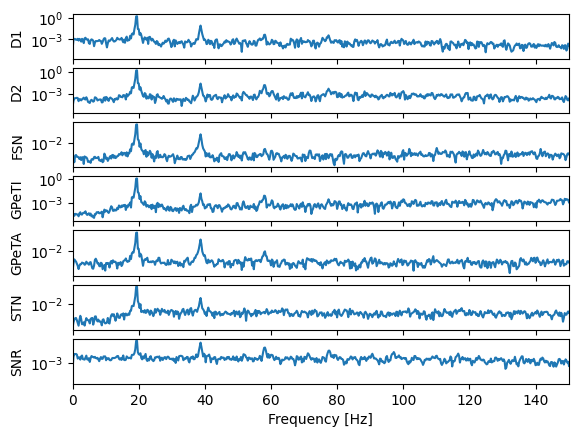

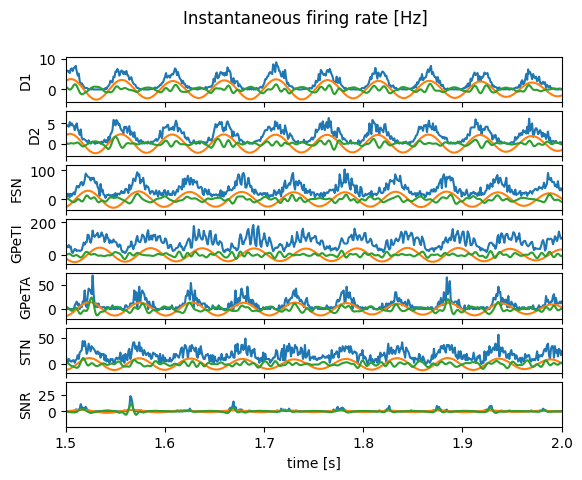

In [31]:
plot_spectrum(sn)
plot_signals(sn)